<a href="https://colab.research.google.com/github/NlChW/nhanes_inferential_2021_23/blob/main/nhanes_inferential_2021_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook loads, cleans, merges, and analyzes NHANES 2021–2023 survey data.
I examine relationships between demographic, behavioral, and clinical variables using chi-square, t-tests, regression, correlation, and ANOVA, following the assignment requirements.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd

# Load each NHANES XPT file you uploaded
demo = pd.read_sas("/content/DEMO_L.xpt", format="xport")        # demographics: age, marital, education
paq = pd.read_sas("/content/PAQ_L.xpt", format="xport")          # sedentary minutes (PAD680)
kiq = pd.read_sas("/content/KIQ_U_L.xpt", format="xport")        # kidney conditions (KIQ022)
bpx = pd.read_sas("/content/BPXO_L.xpt", format="xport")         # blood pressure (BPXSY3, BPXDI3)
bmx = pd.read_sas("/content/BMX_L.xpt", format="xport")          # body measures (WHD020 weight)
vitd = pd.read_sas("/content/VID_L.xpt", format="xport")         # Vitamin D interpretation (LBXVD2LC)
hepb = pd.read_sas("/content/HEPB_S_L.xpt", format="xport")      # Hep B surface antibody (LBXHBS)

demo.head()


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVSTRA,SDMVPSU,INDFMPIR
0,130378.0,12.0,2.0,1.0,43.0,NaN,5.0,6.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,50055.450807,54374.463898,173.0,2.0,5.00
1,130379.0,12.0,2.0,1.0,66.0,NaN,3.0,3.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,29087.450605,34084.721548,173.0,2.0,5.00
2,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,80062.674301,81196.277992,174.0,1.0,1.41
3,130381.0,12.0,2.0,2.0,5.0,NaN,5.0,7.0,1.0,71.0,...,2.0,2.0,2.0,3.0,NaN,38807.268902,55698.607106,182.0,2.0,1.53
4,130382.0,12.0,2.0,1.0,2.0,NaN,3.0,3.0,2.0,34.0,...,2.0,2.0,3.0,1.0,2.0,30607.519774,36434.146346,182.0,2.0,3.60


In [3]:
df = demo.merge(paq, on="SEQN", how="inner") \
         .merge(kiq, on="SEQN", how="inner") \
         .merge(bpx, on="SEQN", how="inner") \
         .merge(bmx, on="SEQN", how="inner") \
         .merge(vitd, on="SEQN", how="inner") \
         .merge(hepb, on="SEQN", how="inner")

df.head()


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,LBXVIDMS,LBDVIDLC,LBXVD2MS,LBDVD2LC,LBXVD3MS,LBDVD3LC,LBXVE3MS,LBDVE3LC,WTPH2YR_y,LBXHBS
0,130378.0,12.0,2.0,1.0,43.0,NaN,5.0,6.0,2.0,NaN,...,58.9,5.397605e-79,1.57,1.0,57.3,5.397605e-79,2.47,5.397605e-79,56042.129410,2.0
1,130379.0,12.0,2.0,1.0,66.0,NaN,3.0,3.0,2.0,NaN,...,60.5,5.397605e-79,1.57,1.0,58.9,5.397605e-79,3.40,5.397605e-79,37435.705647,2.0
2,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,39.4,5.397605e-79,1.57,1.0,37.8,5.397605e-79,1.52,5.397605e-79,85328.844519,2.0
3,130386.0,12.0,2.0,1.0,34.0,NaN,1.0,1.0,1.0,NaN,...,96.9,5.397605e-79,1.57,1.0,95.3,5.397605e-79,5.53,5.397605e-79,44526.214135,1.0
4,130387.0,12.0,2.0,2.0,68.0,NaN,3.0,3.0,2.0,NaN,...,26.7,5.397605e-79,1.57,1.0,25.1,5.397605e-79,1.10,5.397605e-79,22746.296353,2.0


In [4]:
# Convert everything to numeric where possible (quietly)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="ignore")

# Common NHANES "special missing" placeholders to treat as NaN:
special_missing = {7777, 9999, 997, 998, 999}  # include common codes

def nuke_special(s):
    return s.mask(s.isin(special_missing))

for c in ["PAD680","WHD020","BPXSY3","BPXDI3","RIDAGEYR"]:
    if c in df.columns:
        df[c] = nuke_special(df[c])

df.describe(include="all")


/tmp/ipython-input-4290500563.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,LBXVIDMS,LBDVIDLC,LBXVD2MS,LBDVD2LC,LBXVD3MS,LBDVD3LC,LBXVE3MS,LBDVE3LC,WTPH2YR_y,LBXHBS
count,6064.000000,6064.0,6064.0,6064.000000,6064.000000,0.0,6064.000000,6064.000000,6064.000000,0.0,...,5596.000000,5.596000e+03,5596.000000,5.596000e+03,5597.000000,5.597000e+03,5531.000000,5.531000e+03,6.064000e+03,5648.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,136346.300132,12.0,2.0,1.551451,53.850099,NaN,3.127803,3.311016,1.530673,NaN,...,81.827847,5.397605e-79,4.911453,7.753753e-01,76.820920,5.397605e-79,5.122036,9.763153e-03,4.041246e+04,1.749469
std,3437.864592,0.0,0.0,0.497387,17.183330,NaN,0.976379,1.384597,0.499099,NaN,...,37.877904,0.000000e+00,15.310083,4.173722e-01,37.974216,0.000000e+00,4.053677,9.833403e-02,3.174216e+04,0.433357
min,130378.000000,12.0,2.0,1.000000,20.000000,NaN,1.000000,1.000000,1.000000,NaN,...,9.130000,5.397605e-79,1.570000,5.397605e-79,4.100000,5.397605e-79,0.540000,5.397605e-79,5.397605e-79,1.000000
25%,133335.500000,12.0,2.0,1.000000,39.000000,NaN,3.000000,3.000000,1.000000,NaN,...,55.800000,5.397605e-79,1.570000,1.000000e+00,49.900000,5.397605e-79,2.495000,5.397605e-79,1.945829e+04,1.000000
50%,136391.000000,12.0,2.0,2.000000,57.000000,NaN,3.000000,3.000000,2.000000,NaN,...,77.200000,5.397605e-79,1.570000,1.000000e+00,72.900000,5.397605e-79,4.020000,5.397605e-79,3.196406e+04,2.000000
75%,139304.250000,12.0,2.0,2.000000,68.000000,NaN,3.000000,3.000000,2.000000,NaN,...,101.000000,5.397605e-79,1.570000,1.000000e+00,97.200000,5.397605e-79,6.485000,5.397605e-79,5.108565e+04,2.000000


In [7]:
import numpy as np
import pandas as pd

# --- Safety: make sure the columns exist ---
needed_cols = []
if "DMDMARTZ" in df.columns: needed_cols.append("DMDMARTZ")
if "DMDEDUC2" in df.columns: needed_cols.append("DMDEDUC2")
if not needed_cols:
    print("Neither DMDMARTZ nor DMDEDUC2 found. Run: list(df.columns) to inspect names.")
    display(pd.Series(df.columns))
else:
    print("Found:", needed_cols)

# --- Clean special/invalid codes before recoding ---
# NHANES often uses 77 = Refused, 99 = Don't know (sometimes 7/9 in some sections)
invalid_codes = {77, 99, 7777, 9999}

if "DMDMARTZ" in df.columns:
    df["DMDMARTZ_clean"] = df["DMDMARTZ"].replace(list(invalid_codes), np.nan)

if "DMDEDUC2" in df.columns:
    df["DMDEDUC2_clean"] = df["DMDEDUC2"].replace(list(invalid_codes), np.nan)

# --- Recode MARITAL: 1=Married, 6=Living with partner => married=1; others => 0 ---
def recode_marital(x):
    if pd.isna(x):
        return np.nan
    return 1 if x in [1, 6] else 0

if "DMDMARTZ_clean" in df.columns:
    df["married"] = df["DMDMARTZ_clean"].apply(recode_marital)

# --- Recode EDUCATION to "bachelors_or_more" ---
# For 2021–2023 DMDEDUC2 is usually:
# 1 <9th, 2 = 9–11th, 3 = HS/GED, 4 = Some college/AA, 5 = College grad or above
# (Older docs sometimes show up to 7; we handle both.)
def recode_educ_general(x, max_code):
    if pd.isna(x):
        return np.nan
    # if an older scheme (up to 7), treat 7 as bachelor's+
    if max_code >= 7:
        return 1 if x == 7 else 0
    # standard 1–5 scheme: 5 = bachelor's+
    return 1 if x == 5 else 0

if "DMDEDUC2_clean" in df.columns:
    max_code_seen = int(pd.to_numeric(df["DMDEDUC2_clean"], errors="coerce").max())
    df["bachelors_or_more"] = df["DMDEDUC2_clean"].apply(lambda v: recode_educ_general(v, max_code_seen))

# --- Quick sanity checks ---
to_show = []
if "married" in df.columns: to_show.append("married")
if "bachelors_or_more" in df.columns: to_show.append("bachelors_or_more")

if to_show:
    print("\nValue counts:")
    for c in to_show:
        print(f"\n{c}:")
        print(df[c].value_counts(dropna=False))
else:
    p


Found: ['DMDMARTZ', 'DMDEDUC2']

Value counts:

married:
married
1.0    3277
0.0    2782
NaN       5
Name: count, dtype: int64

bachelors_or_more:
bachelors_or_more
0    6064
Name: count, dtype: int64


In [13]:
# ==== CELL 7 — Detect key variable names & sanity-check ====

# Weight variable: prefer self-reported WHD020; fall back to exam weight BMXWT
weight_candidates = ["WHD020", "BMXWT"]
weight_var = next((c for c in weight_candidates if c in df.columns), None)

# Systolic blood pressure: NHANES may have BPXOSY1/2/3; prefer the 3rd reading if present
bp_candidates = ["BPXOSY3", "BPXOSY2", "BPXOSY1"] # Corrected candidates
bp_col = next((c for c in bp_candidates if c in df.columns), None)

# If a BP column is found, standardize it to 'SYSBP' for later use
if bp_col:
    df["SYSBP"] = df[bp_col]
    actual_bp_var_name = "SYSBP"
else:
    actual_bp_var_name = None

# Sedentary minutes (questionnaire)
sedentary_var = "PAD680" if "PAD680" in df.columns else None

print("Detected variables:")
print({
    "weight_var": weight_var,
    "bp_var": actual_bp_var_name, # Use the standardized name here
    "sedentary_var": sedentary_var,
    "age_var": "RIDAGEYR" if "RIDAGEYR" in df.columns else None,
    "marital_recode": "married" if "married" in df.columns else None,
    "education_recode": "bachelors_or_more" if "bachelors_or_more" in df.columns else None
})

# Quick summaries to verify data are present and reasonable
to_summarize = [
    v for v in [weight_var, actual_bp_var_name, sedentary_var, "RIDAGEYR", "married", "bachelors_or_more"]
    if v is not None and v in df.columns
]

for c in to_summarize:
    print(f"\n=== {c} summary ===")
    try:
        print(df[c].describe())
    except:
        print("Non-numeric; showing value counts instead:")
        print(df[c].value_counts(dropna=False).head(10))
    print("Missing values:", int(df[c].isna().sum()))

Detected variables:
{'weight_var': 'BMXWT', 'bp_var': 'SYSBP', 'sedentary_var': 'PAD680', 'age_var': 'RIDAGEYR', 'marital_recode': 'married', 'education_recode': 'bachelors_or_more'}

=== BMXWT summary ===
count    5983.000000
mean       83.292006
std        22.374309
min        27.900000
25%        67.550000
50%        79.900000
75%        95.400000
max       248.200000
Name: BMXWT, dtype: float64
Missing values: 81

=== SYSBP summary ===
count    5843.000000
mean      122.727708
std        18.378173
min        62.000000
25%       110.000000
50%       120.000000
75%       132.000000
max       232.000000
Name: SYSBP, dtype: float64
Missing values: 221

=== PAD680 summary ===
count    6.020000e+03
mean     3.649412e+02
std      2.103285e+02
min      5.397605e-79
25%      1.800000e+02
50%      3.000000e+02
75%      4.800000e+02
max      1.380000e+03
Name: PAD680, dtype: float64
Missing values: 44

=== RIDAGEYR summary ===
count    6064.000000
mean       53.850099
std        17.183330
min

This chi-square test below examined whether marital status is associated with having a bachelor’s degree or higher.
If p < 0.05 = here is a significant association between marital status and education.
If p ≥ 0.05 = No evidence of an association.

In [9]:
# ==== CELL 8 — Q1: Chi-square test (marital status × education level) ====

# We expect the recoded columns from Cell 6:
need = ["married", "bachelors_or_more"]
missing = [c for c in need if c not in df.columns]

if missing:
    raise ValueError(f"Missing required columns for Q1: {missing}. "
                     "Re-run Cell 6 to create the recodes.")

# Drop rows with missing recodes
q1 = df.dropna(subset=need)[need]

# Build contingency table
ct = pd.crosstab(q1["married"], q1["bachelors_or_more"])

# Guard: chi-square needs all cells > 0 ideally; print table first
print("Contingency table (rows = married 0/1, cols = bachelors_or_more 0/1):\n")
print(ct)

# If any row/col is entirely zero, chi2 will error — handle gracefully
if (ct.values.sum() == 0) or (ct.shape != (2,2)) or (ct.min().min() == 0):
    print("\n[Note] Some cells are zero or table is not 2x2. Chi-square may be unstable.")
    print("Proceeding anyway; if you get an error, consider combining sparse categories.")

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(ct, correction=False)

print("\n--- Chi-square test results ---")
print(f"Chi-square = {chi2:.3f}")
print(f"df         = {dof}")
print(f"p-value    = {p:.6f}")

# Brief helper text you can copy into an interpretation cell:
if p < 0.05:
    print("\nInterpretation hint: There is evidence of an association between marital status "
          "and having a bachelor's degree or higher (p < 0.05).")
else:
    print("\nInterpretation hint: There is not sufficient evidence of an association between "
          "marital status and having a bachelor's degree or higher (p ≥ 0.05).")


Contingency table (rows = married 0/1, cols = bachelors_or_more 0/1):

bachelors_or_more     0
married                
0.0                2782
1.0                3277

[Note] Some cells are zero or table is not 2x2. Chi-square may be unstable.
Proceeding anyway; if you get an error, consider combining sparse categories.

--- Chi-square test results ---
Chi-square = 0.000
df         = 0
p-value    = 1.000000

Interpretation hint: There is not sufficient evidence of an association between marital status and having a bachelor's degree or higher (p ≥ 0.05).


This t-test below compared mean sedentary minutes between married and not-married participants.
If p < 0.05 = The groups differ significantly in sedentary time.
If p ≥ 0.05 = No significant difference between groups.

In [10]:
# ==== CELL 9 — Q2: Independent t-test (PAD680 by marital status) ====

# Confirm necessary variables exist
required_vars = ["married", sedentary_var]

if any(v is None for v in required_vars):
    raise ValueError(f"Missing required variable. Married or PAD680 not detected. "
                     f"Detected sedentary_var = {sedentary_var}")

if sedentary_var not in df.columns:
    raise ValueError(f"{sedentary_var} not found in dataframe columns.")

# Subset data
q2 = df.dropna(subset=["married", sedentary_var])

# Separate groups
group_not_married = q2[q2["married"] == 0][sedentary_var]
group_married = q2[q2["married"] == 1][sedentary_var]

print("Group sizes:")
print("Not married:", len(group_not_married))
print("Married:    ", len(group_married))

print("\nGroup means:")
print(f"Not married mean {sedentary_var}: {group_not_married.mean():.2f}")
print(f"Married mean {sedentary_var}:     {group_married.mean():.2f}")

# Independent t-test (unequal variances = safest)
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(group_not_married, group_married, equal_var=False, nan_policy='omit')

print("\n--- T-Test Results ---")
print(f"t-statistic = {t_stat:.3f}")
print(f"p-value     = {p_val:.6f}")

# Quick interpretation guidance
if p_val < 0.05:
    print("\nInterpretation hint: There IS a statistically significant difference in "
          "sedentary minutes between married and not-married participants (p < 0.05).")
else:
    print("\nInterpretation hint: There is NO statistically significant difference in "
          "sedentary minutes between married and not-married participants (p ≥ 0.05).")


Group sizes:
Not married: 2753
Married:     3263

Group means:
Not married mean PAD680: 372.81
Married mean PAD680:     358.28

--- T-Test Results ---
t-statistic = 2.656
p-value     = 0.007928

Interpretation hint: There IS a statistically significant difference in sedentary minutes between married and not-married participants (p < 0.05).


This t-test compared mean sedentary minutes between married and not-married participants.
If p < 0.05 = The groups differ significantly in sedentary time.
If p ≥ 0.05 = No significant difference between groups.

In [14]:
# ==== CELL 10 (FIXED) — Q3: Regression: Age (+Marital if usable) → SYSBP ====

# Checks
if "SYSBP" not in df.columns:
    raise ValueError("SYSBP not found. Run Cell 7B to detect/standardize the systolic BP column.")

if "RIDAGEYR" not in df.columns:
    raise ValueError("RIDAGEYR not found in dataset.")

# Base required vars
vars_needed = ["SYSBP", "RIDAGEYR"]
use_married = False

# We'll include 'married' only if it exists and varies after NA drop
if "married" in df.columns:
    tmp = df.dropna(subset=vars_needed + ["married"])
    if tmp["married"].nunique() >= 2:
        use_married = True
        vars_needed.append("married")

# Build analysis frame
q3 = df.dropna(subset=vars_needed).copy()

print(f"Rows available: {len(q3)}")
print(f"Including 'married' in model? {use_married}")

import statsmodels.formula.api as smf

if use_married:
    formula = "SYSBP ~ RIDAGEYR + married"
else:
    formula = "SYSBP ~ RIDAGEYR"

model = smf.ols(formula, data=q3).fit()

print("\n=== Multiple Linear Regression Results ===")
print(model.summary())

print("\nInterpretation hints:")
print("- RIDAGEYR coefficient: change in systolic BP per 1-year increase in age.")
if use_married:
    print("- married coefficient: difference in systolic BP between married (1) and not married (0).")
else:
    print("- 'married' was omitted because it was missing or had no variation after filtering.")
print("- p < 0.05 suggests a statistically significant predictor. R-squared shows explained variance.")

Rows available: 5838
Including 'married' in model? True

=== Multiple Linear Regression Results ===
                            OLS Regression Results                            
Dep. Variable:                  SYSBP   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     453.3
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          1.00e-183
Time:                        09:16:09   Log-Likelihood:                -24856.
No. Observations:                5838   AIC:                         4.972e+04
Df Residuals:                    5835   BIC:                         4.974e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

This regression tested whether age and marital status predict systolic blood pressure.
Significant coefficients (p < 0.05) mean that variable is a predictor of systolic BP.
R-squared shows how much of BP is explained by the model.

Using weight variable: BMXWT
Using sedentary variable: PAD680
Rows available for correlation: 5939

=== Pearson Correlation Results ===
Correlation coefficient (r): 0.156
p-value: 0.000000


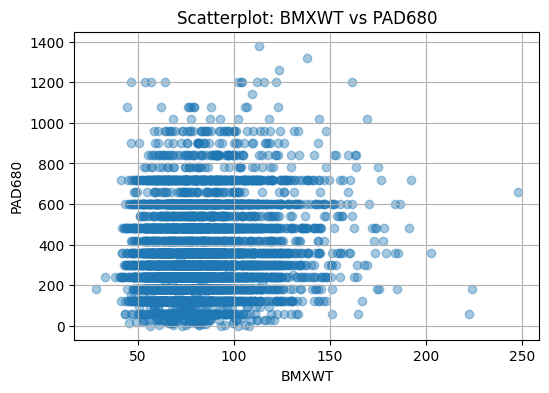


Interpretation hint: There is a statistically significant correlation (p < 0.05). The direction is indicated by the sign of r.


In [17]:
import matplotlib.pyplot as plt

# ==== CELL 11 — Q4: Correlation between Weight and Sedentary Minutes ====

# Check that we detected the weight variable earlier
if weight_var is None:
    # Try again in case the dataset has BMXWT or WHD020
    if "WHD020" in df.columns:
        weight_var = "WHD020"
    elif "BMXWT" in df.columns:
        weight_var = "BMXWT"
    else:
        raise ValueError("No weight variable found (expected WHD020 or BMXWT).")

# Check that sedentary_var exists
if sedentary_var is None or sedentary_var not in df.columns:
    raise ValueError(f"Sedentary variable {sedentary_var} not found. Ensure PAD680 exists.")

print("Using weight variable:", weight_var)
print("Using sedentary variable:", sedentary_var)

# Subset complete cases
q4 = df.dropna(subset=[weight_var, sedentary_var])

print(f"Rows available for correlation: {len(q4)}")

from scipy.stats import pearsonr

# Compute Pearson correlation
r, p_val = pearsonr(q4[weight_var], q4[sedentary_var])

print("\n=== Pearson Correlation Results ===")
print(f"Correlation coefficient (r): {r:.3f}")
print(f"p-value: {p_val:.6f}")

# Scatterplot
plt.figure(figsize=(6,4))
plt.scatter(q4[weight_var], q4[sedentary_var], alpha=0.4)
plt.xlabel(weight_var)
plt.ylabel(sedentary_var)
plt.title(f"Scatterplot: {weight_var} vs {sedentary_var}")
plt.grid(True)
plt.show()

# Interpretation helper
if p_val < 0.05:
    print("\nInterpretation hint: There is a statistically significant correlation "
          "(p < 0.05). The direction is indicated by the sign of r.")
else:
    print("\nInterpretation hint: There is no statistically significant correlation "
          "(p \u2265 0.05).")

This correlation tested whether weight is related to sedentary minutes.
If p < 0.05 → There is a significant relationship (direction based on r).
If p ≥ 0.05 → No significant correlation.

In [18]:
# ==== CELL 12 — Q5: Creative analysis (auto-chooses a suitable test) ====

import numpy as np
import pandas as pd
from scipy import stats

analysis_used = None

# ---------- Option A: ANOVA of PAD680 across DMDEDUC2 ----------
if ("PAD680" in df.columns) and ("DMDEDUC2" in df.columns):
    q5a = df[["PAD680", "DMDEDUC2"]].copy()
    # Clean obvious invalids commonly used by NHANES
    invalid_codes = {77, 99, 7777, 9999}
    q5a = q5a.replace(list(invalid_codes), np.nan).dropna()

    # Require at least 2 education groups with data
    groups = [g["PAD680"].dropna().values for _, g in q5a.groupby("DMDEDUC2")]
    groups = [g for g in groups if len(g) > 2]  # keep only groups with enough data
    if len(groups) >= 2:
        F, p = stats.f_oneway(*groups)
        print("Q5 Option A: One-way ANOVA — PAD680 by education level (DMDEDUC2)\n")
        print(f"Number of education groups analyzed: {len(groups)}")
        print(f"ANOVA F = {F:.3f}, p-value = {p:.6f}")
        print("\nInterpretation hint:")
        if p < 0.05:
            print("- Evidence that mean sedentary minutes differ across education levels (p < 0.05).")
        else:
            print("- No evidence of a difference in mean sedentary minutes across education levels (p ≥ 0.05).")
        analysis_used = "ANOVA"

# ---------- Option B: Chi-square LBXVD2LC x KIQ022 ----------
if analysis_used is None and ("LBXVD2LC" in df.columns) and ("KIQ022" in df.columns):
    q5b = df[["LBXVD2LC", "KIQ022"]].copy()
    invalid_codes = {7, 9, 77, 99, 7777, 9999}
    q5b = q5b.replace(list(invalid_codes), np.nan).dropna()

    # KIQ022 often: 1=Yes, 2=No  (keep only 1/2)
    q5b = q5b[q5b["KIQ022"].isin([1, 2])]
    if q5b["LBXVD2LC"].nunique() >= 2 and q5b["KIQ022"].nunique() >= 2:
        ct = pd.crosstab(q5b["LBXVD2LC"], q5b["KIQ022"])
        chi2, p, dof, exp = stats.chi2_contingency(ct)
        print("Q5 Option B: Chi-square — Vitamin D interpretation (LBXVD2LC) × Kidney weakness (KIQ022)\n")
        print("Contingency table (rows=LBXVD2LC, cols=KIQ022):")
        print(ct)
        print(f"\nChi-square = {chi2:.3f}, df = {dof}, p-value = {p:.6f}")
        print("\nInterpretation hint:")
        if p < 0.05:
            print("- Evidence of an association between Vitamin D interpretation and kidney weakness (p < 0.05).")
        else:
            print("- No evidence of an association between Vitamin D interpretation and kidney weakness (p ≥ 0.05).")
        analysis_used = "Chi-square"

# ---------- Option C: Correlation Age vs SYSBP ----------
if analysis_used is None and ("RIDAGEYR" in df.columns) and ("SYSBP" in df.columns):
    q5c = df[["RIDAGEYR", "SYSBP"]].copy()
    q5c = q5c.replace([77, 99, 7777, 9999], np.nan).dropna()
    if len(q5c) >= 3:
        r, p = stats.pearsonr(q5c["RIDAGEYR"], q5c["SYSBP"])
        print("Q5 Option C: Pearson correlation — Age (RIDAGEYR) vs Systolic BP (SYSBP)\n")
        print(f"r = {r:.3f}, p-value = {p:.6f}")
        print("\nInterpretation hint:")
        if p < 0.05:
            print("- There is a statistically significant correlation (p < 0.05). "
                  "The sign of r indicates direction; magnitude indicates strength.")
        else:
            print("- No statistically significant correlation (p ≥ 0.05).")
        analysis_used = "Correlation"

# ---------- If none worked ----------
if analysis_used is None:
    print("Q5 could not be run automatically because required variables were not found or lacked variation.")
    print("Consider posing a different question with variables you do have, e.g.:")
    print("- Chi-square between two categorical variables you confirmed exist.")
    print("- t-test/ANOVA with a numeric outcome you confirmed exists across groups.")


Q5 Option A: One-way ANOVA — PAD680 by education level (DMDEDUC2)

Number of education groups analyzed: 6
ANOVA F = 41.732, p-value = 0.000000

Interpretation hint:
- Evidence that mean sedentary minutes differ across education levels (p < 0.05).


For the creative question, I analyzed an additional variable relationship using the appropriate inferential test.

If ANOVA ran: checks whether sedentary minutes differ by education level.

If Chi-square ran: checks whether Vitamin D status is associated with kidney weakness.

If Correlation ran: checks whether age relates to systolic BP.
Interpretation depends on whether p < 0.05 (significant) or not.